In [2]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [4]:
!curl -o cats-and-dogs.zip "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0  635k    0     0  1789k      0  0:07:30 --:--:--  0:07:30 1810k
  0  786M    0 6182k    0     0  4563k      0  0:02:56  0:00:01  0:02:55 4576k
  1  786M    1 12.0M    0     0  5216k      0  0:02:34  0:00:02  0:02:32 5224k
  2  786M    2 18.4M    0     0  5623k      0  0:02:23  0:00:03  0:02:20 5631k
  3  786M    3 24.2M    0     0  5708k      0  0:02:21  0:00:04  0:02:17 5713k
  3  786M    3 30.6M    0     0  5853k      0  0:02:17  0:00:05  0:02:12 6142k
  4  786M    4 37.2M    0     0  5999k      0  0:02:14  0:00:06  0:02:08 6389k
  5  786M    5 43.7M    0     0  6093k      0  0:02:12  0:00:07  0:02:05 6506k
  6  786M    6 49.7M    0     0  6093k      0  0:02:12  0:00:08  0:02:04 6408k
  7  786M    7 55.7M    0     0  6099k      0  0:02

In [13]:
def get_valid(file_path):
    correct_files=[]
    for name in os.listdir(file_path):
        try:
            img=Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

In [16]:
local_zip = './cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
#zipfile.ZipFile() otwiera plik ZIP zawierający zdjęcia kotów i psów
#extractall('/tmp') rozpakowuje wszystkie pliki do katalogu /tmp

classes = ['Cat', 'Dog']
original_cat_path = '/tmp/PetImages/Cat'
original_dog_path = '/tmp/PetImages/Dog'
#classes definiuje kategorie danych: koty (Cat) i psy (Dog).
#original_cat_path i original_dog_path wskazują, gdzie znajdują się zdjęcia kotów i psów w rozpakowanym katalogu

original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)
#get_valid sprawdza czy obrazki nie sa uszkodzone
#original_cat i original_dog to listy poprawnych nazw plików dla kotów i psów

random.seed(101)
random.shuffle(original_cat)
random.shuffle(original_dog)
#Ustawienie ziarna losowości (seed), aby zapewnić powtarzalność losowego tasowania
#Tasowanie list original_cat i original_dog w losowej kolejności

size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
#size to liczba obrazów, biorąc najmniejszą liczbę między kotami i psami, aby zachować równowagę między klasami
#Obliczanie liczby obrazów do każdego zestawu:
#70% do treningu (train_size)
#20% do walidacji (valid_size)
#Pozostałe 10% do testu (test_size)

base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}
#tworzenie katalogow
#Tworzenie głównego katalogu dataset, który będzie przechowywał dane

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'
#Tworzenie katalogów train, valid, test w folderze dataset
#W każdym z tych katalogów tworzenie podkatalogów dla klas: Cat i Dog
#Każdy podkatalog jest zapisywany w słowniku directories dla łatwego dostępu

index=0
for name_cat, name_dog in zip(original_cat, original_dog):
    if index <= train_size:
        type_of_dataset = 'train'
    elif train_size < index <= (train_size + valid_size):
        type_of_dataset = 'valid'
    elif (train_size +valid_size) < index <= (train_size +valid_size +test_size):
        type_of_dataset = 'test'
    shutil.copyfile(src=(original_cat_path + '/' + name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
    shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
    index += 1
#zip(original_cat, original_dog) iteruje jednocześnie po nazwach plików kotów i psów.
#Na podstawie indeksu (index) określany jest typ zestawu: train, valid, test
#shutil.copyfile kopiuje obraz z katalogu źródłowego do odpowiedniego katalogu docelowego, zgodnie z zestawem i klasą
#Wynik: Wszystkie obrazy są uporządkowane w katalogach

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')
#Wyświetlenie liczby obrazów w każdym zestawie (train, valid, test) dla kotów i psów

#Podsumowanie
#Rozpakowanie danych: Pobierane dane są rozpakowywane i weryfikowane.
#Tasowanie i podział: Dane są tasowane i podzielone na zestawy treningowe, walidacyjne i testowe w proporcji 70-20-10.
#Tworzenie struktury katalogów: Dane są organizowane w katalogach, co ułatwia ich użycie z narzędziami takimi jak ImageDataGenerator.
#Kopiowanie danych: Obrazy są kopiowane do odpowiednich katalogów zgodnie z podziałem.

Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


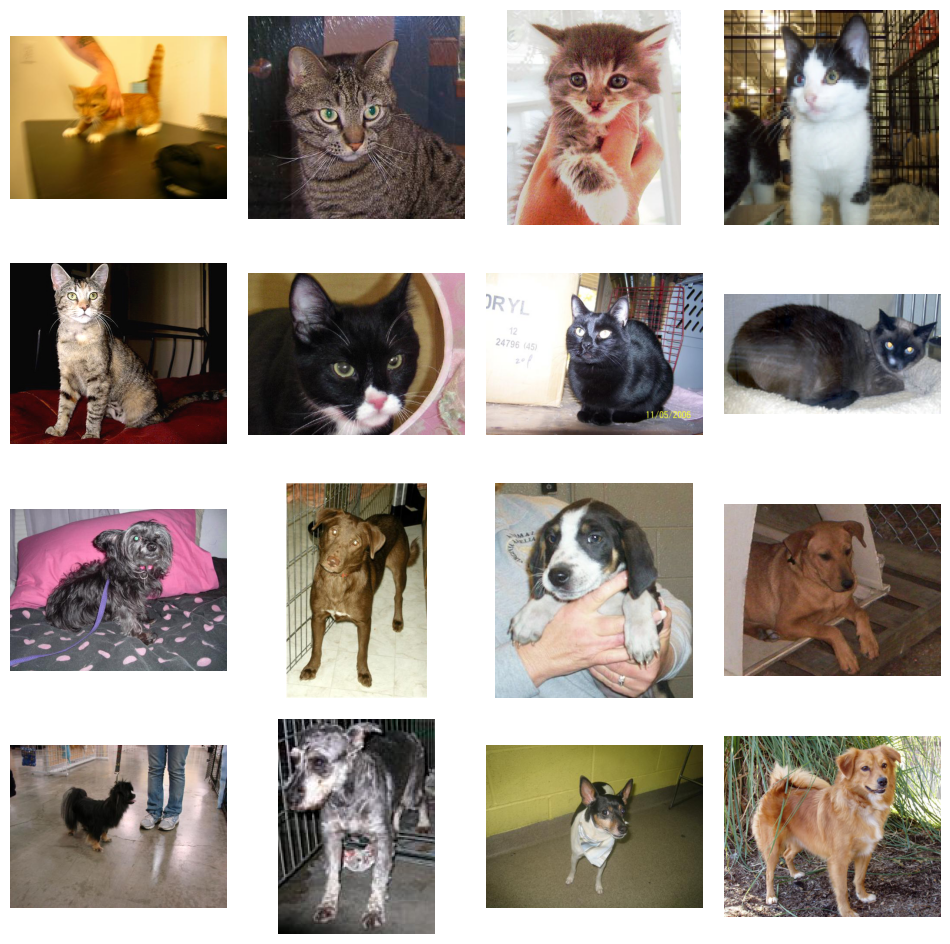

In [18]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
#hspace=0.1: Odstęp w pionie.
#wspace=0.1: Odstęp w poziomie

for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
#ax.spines['...'].set_visible(False): Ukrywa ramki wokół obrazu (top, left, bottom, right)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
#i+9: Obrazy psów są wyświetlane na podwykresach od 9 do 16 (zaczynają się od 9, ponieważ podwykresy 1–8 są zajęte przez koty).
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [22]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [23]:
models = []
os.mkdir("history")
os.mkdir("charts")

In [24]:
model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss = 'binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          67,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,501 (263.68 KB)

 Trainable params: 67,501 (263.68 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [28]:
history_baseline = model_baseline.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])
history_baseline_df = pd.DataFrame(history_baseline.history)
#history_baseline.history: Po zakończeniu treningu obiekt zwrócony przez fit_generator (lub fit) zawiera informacje o przebiegu treningu. 
#Jest to słownik zawierający dane takie jak:
#loss: Strata (np. błąd) na danych treningowych w każdej epoce.
#accuracy: Dokładność na danych treningowych w każdej epoce.
#val_loss: Strata na danych walidacyjnych w każdej epoce.
#val_accuracy: Dokładność na danych walidacyjnych w każdej epoce.
#pd.DataFrame(): Konwertuje ten słownik na obiekt DataFrame w Pandas, co ułatwia analizowanie danych i zapisywanie ich do pliku.
history_baseline_csv_file = 'history/history_baseline.csv'
#Tworzysz zmienną zawierającą ścieżkę do pliku CSV, w którym zapiszesz historię treningu. W tym przypadku plik nazywa się history_baseline.csv 
#i jest zapisany w katalogu history

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)
#with open(..., mode='w') as f:: Otwierasz plik o ścieżce history_baseline_csv_file w trybie zapisu ('w'). Jeśli plik już istnieje, zostanie nadpisany.
#history_baseline_df.to_csv(f): Zapisujesz dane z DataFrame (history_baseline_df) do pliku w formacie CSV

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 102s 744ms/step - accuracy: 0.5154 - loss: 1.0492 - val_accuracy: 0.4988 - val_loss: 1.3091
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 61s 451ms/step - accuracy: 0.5148 - loss: 0.9362 - val_accuracy: 0.5028 - val_loss: 1.0929
Epoch 3/1000
  1/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4062 - loss: 1.2611

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.4062 - loss: 1.2793 - val_accuracy: 0.5128 - val_loss: 0.9771
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 44s 325ms/step - accuracy: 0.5339 - loss: 0.8957 - val_accuracy: 0.5116 - val_loss: 0.9671
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 37s 271ms/step - accuracy: 0.5176 - loss: 0.9388 - val_accuracy: 0.5112 - val_loss: 0.8491
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.4994 - loss: 0.8512 - val_accuracy: 0.5268 - val_loss: 0.8386
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 35s 254ms/step - accuracy: 0.5106 - loss: 0.9322 - val_accuracy: 0.5349 - val_loss: 0.7520
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 235ms/step - accuracy: 0.5337 - loss: 0.8851 - val_accuracy: 0.5176 - val_loss: 0.8775
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.4295 - loss: 1.1622 - val_accuracy: 0.4944 - val_loss: 1.0231
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step - accuracy: 0.5313 - loss: 0.

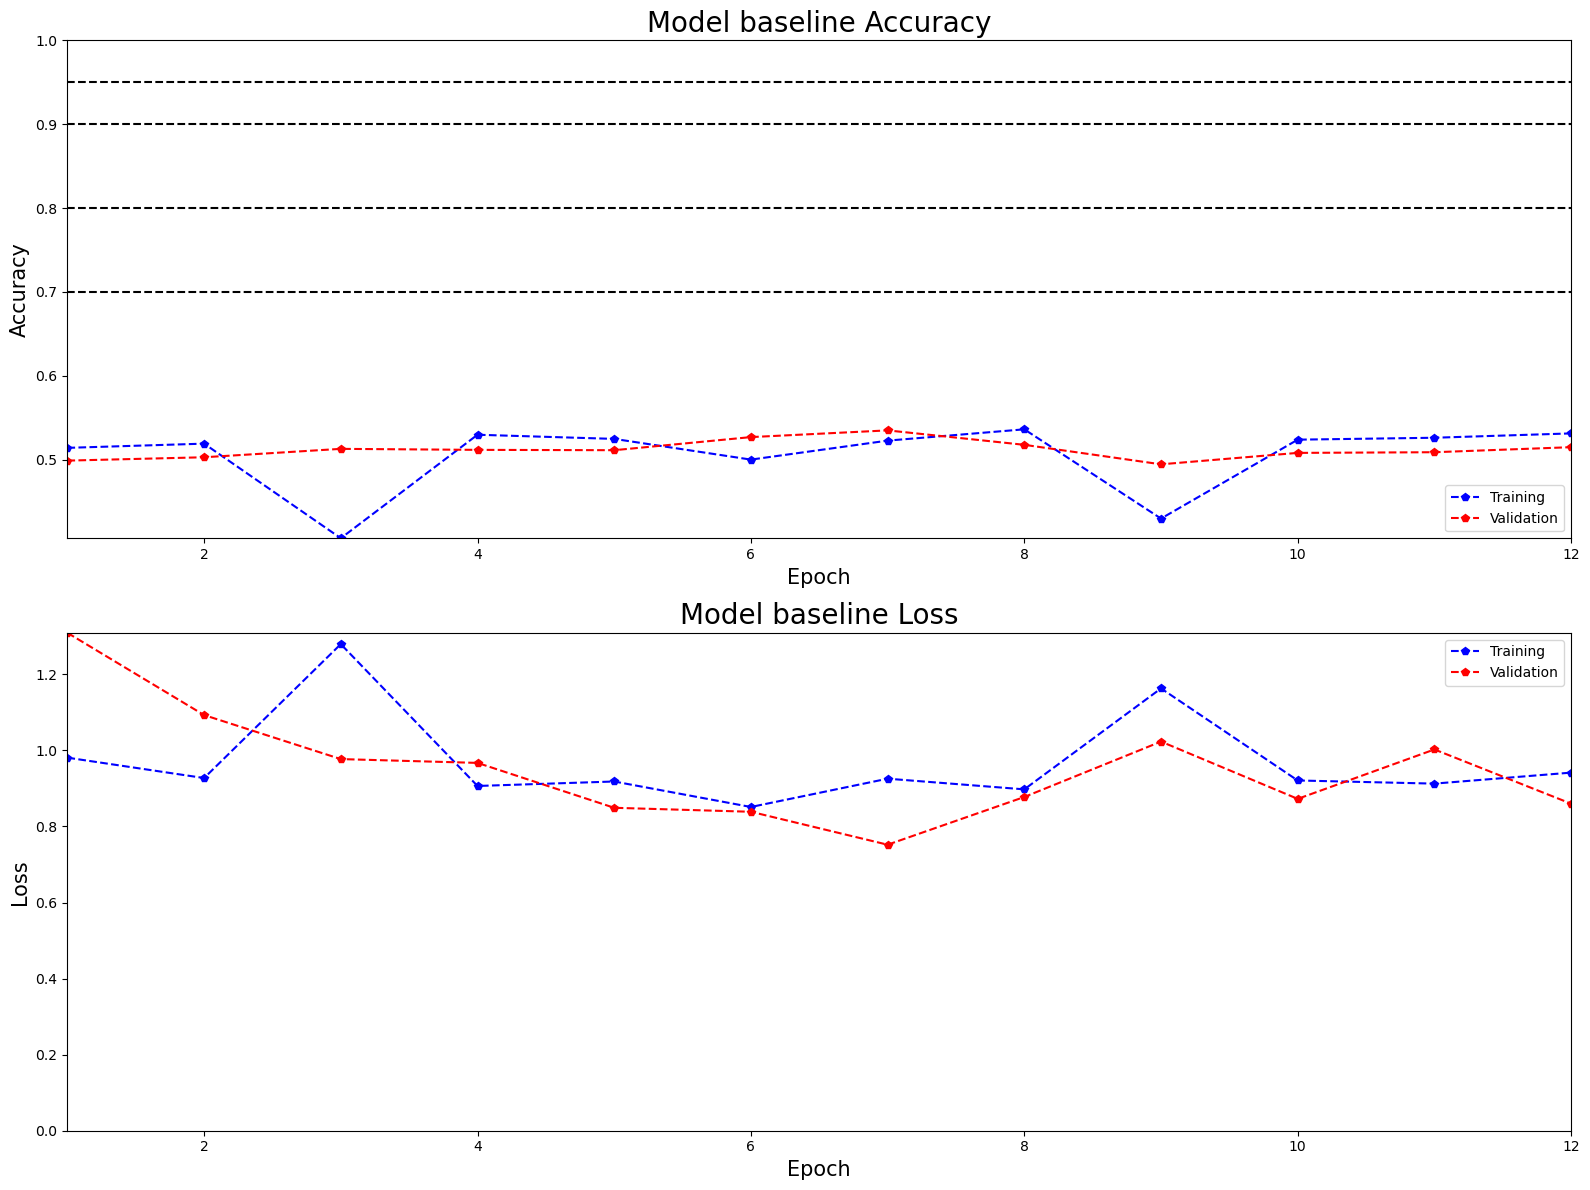

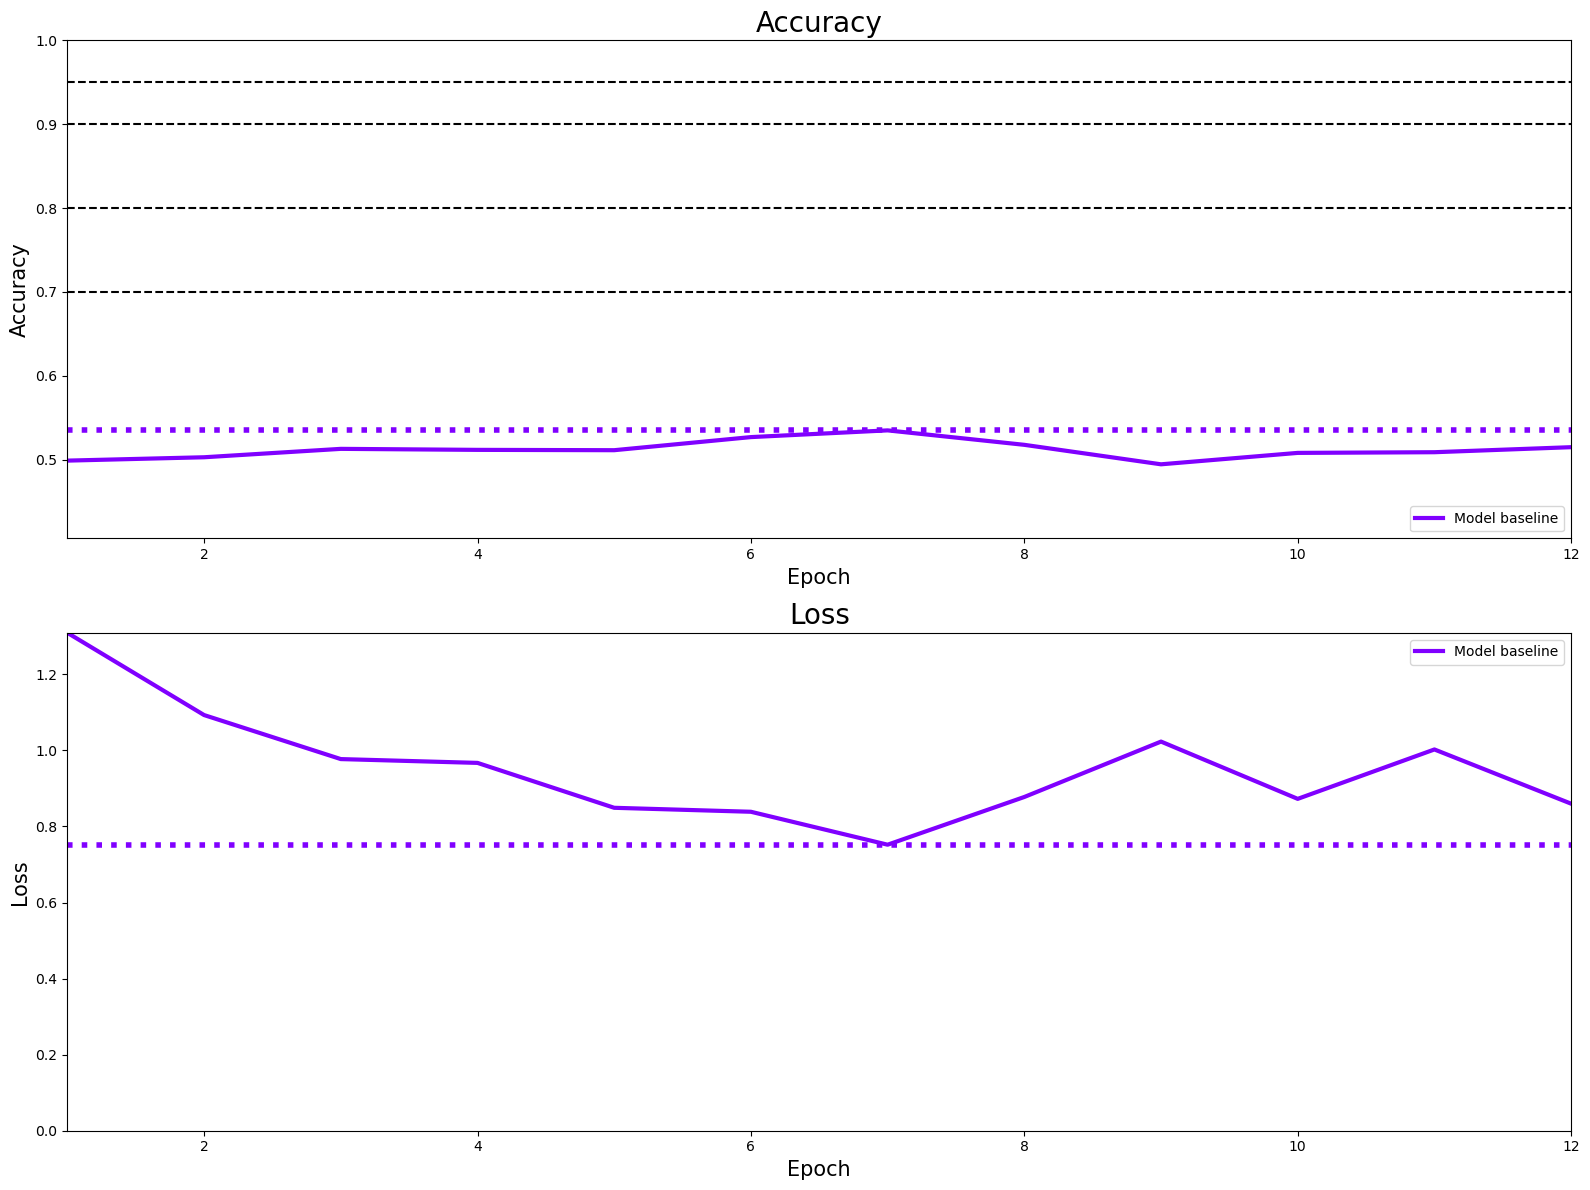

In [32]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))
#max_index – przechowuje maksymalną liczbę epok w historii treningu spośród wszystkich modeli.
#min_accuracy – najmniejsza wartość dokładności (dla treningu i walidacji).
#max_loss – największa wartość błędu (dla treningu i walidacji).
#colors – generuje paletę kolorów, która zostanie użyta do odróżnienia modeli w wykresach

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index +=1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())
#W tej pętli przetwarzamy historię każdego modelu (z pliku CSV). Dla każdego modelu:
#Określamy największą liczbę epok (max_index).
#Sprawdzamy minimalną dokładność (zarówno dla treningu, jak i walidacji).
#Sprawdzamy największą wartość funkcji straty.
#Efekt: mamy globalne wartości zakresów dla wykresów (np. zakres osi y dla dokładności).

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
#Rysujemy wykres dla dokładności treningowej i walidacyjnej:

    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
#Niebieskie punkty z przerywaną linią: dokładność treningowa.
#Czerwone punkty z przerywaną linią: dokładność walidacyjn
    
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass
#Dodatkowe elementy:

#Linie pomocnicze na wykresie dla wartości progowych dokładności (np. 0.7, 0.8 itp.).
#Jeśli dokładność walidacyjna osiągnie te wartości, dodajemy linię pionową oznaczającą epokę.

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
#Rysujemy wykres dla straty treningowej i walidacyjnej:
#Niebieskie punkty z przerywaną linią: strata treningowa.
#Czerwone punkty z przerywaną linią: strata walidacyjna

    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()
#Dodatkowe elementy:
#Linie pomocnicze na osi y (np. minimalne wartości funkcji straty).
#Zapisujemy wykresy do pliku PNG z wysoką jakością (600 dpi).

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)
#Dla każdego modelu rysujemy wykres dokładności walidacyjnej z unikalnym kolorem.
#Dodajemy linię poziomą wskazującą maksymalną wartość dokładności walidacyjnej.

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
#Podobnie jak wyżej, ale dla funkcji straty.

ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)

plt.show()

#Podsumowanie: Co robi ten kod?
#Wczytuje dane historyczne treningu dla różnych modeli z plików CSV.
#Dla każdego modelu generuje:
#Oddzielny wykres dokładności i funkcji straty.
#Zapisuje je do plików PNG.
#Porównuje wyniki wszystkich modeli na jednym wykresie:
#Porównuje dokładność walidacyjną.
#Porównuje funkcję straty walidacyjną.

In [33]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 54760)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          54,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,041 (215.00 KB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history_simple_1 = model_simple_1.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 45s 320ms/step - accuracy: 0.5363 - loss: 0.9728 - val_accuracy: 0.6318 - val_loss: 0.6251
Epoch 2/1000
 78/136 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - accuracy: 0.6569 - loss: 0.6191

C:\Users\matyj\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 318ms/step - accuracy: 0.6599 - loss: 0.6128 - val_accuracy: 0.6747 - val_loss: 0.6043
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.6836 - loss: 0.6226

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.6797 - loss: 0.6032 - val_accuracy: 0.7099 - val_loss: 0.5743
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 288ms/step - accuracy: 0.7236 - loss: 0.5427 - val_accuracy: 0.7079 - val_loss: 0.5775
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - accuracy: 0.7591 - loss: 0.5023 - val_accuracy: 0.7236 - val_loss: 0.5700
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7609 - loss: 0.5203 - val_accuracy: 0.7159 - val_loss: 0.5695
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - accuracy: 0.7854 - loss: 0.4651 - val_accuracy: 0.7159 - val_loss: 0.5821
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 282ms/step - accuracy: 0.8000 - loss: 0.4402 - val_accuracy: 0.7240 - val_loss: 0.5677
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8204 - loss: 0.4681 - val_accuracy: 0.7332 - val_loss: 0.5468
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 299ms/step - accuracy: 0.8276 - loss: 0.3

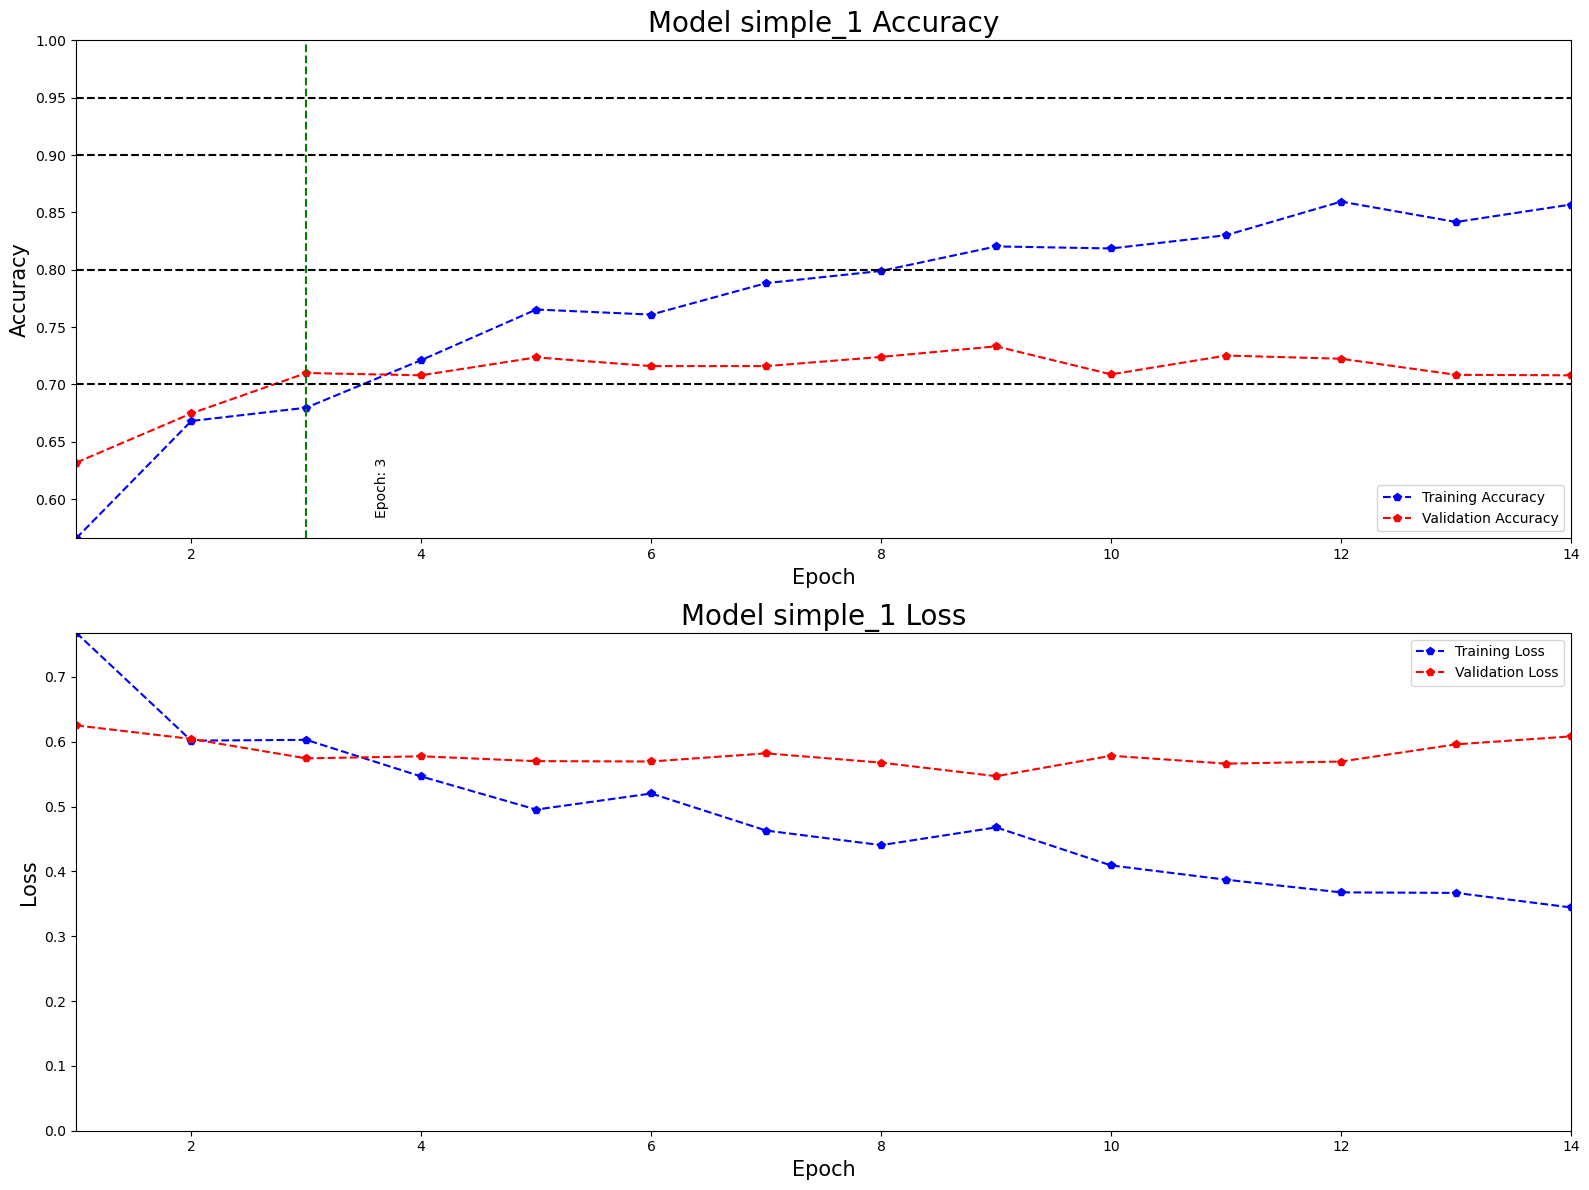

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Wczytaj historię modelu
df = pd.read_csv('history/history_simple_1.csv', index_col=0)
df.index += 1  # Indeks zaczyna się od 1, co odpowiada epokom

# Określ zakresy
max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

# Generowanie wykresów dla jednego modelu
fig = plt.figure(figsize=(16, 12))

# Wykres dokładności
ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model simple_1 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])

# Linie pomocnicze dla progów dokładności
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')

# Wykres funkcji straty
ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model simple_1 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')

# Zapis wykresu
plt.tight_layout()
plt.savefig(f'charts/train_history_simple_1.png', transparent=True, dpi=600)
plt.show()


In [37]:
model_simple_2 = Sequential()
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 56250)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          56,251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,531 (220.82 KB)

 Trainable params: 56,531 (220.82 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history_simple_2 = model_simple_2.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_2_df = pd.DataFrame(history_simple_2.history)
history_simple_2_csv_file = 'history/history_simple_2.csv'

with open(history_simple_2_csv_file, mode='w') as f:
    history_simple_2_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - accuracy: 0.5266 - loss: 0.8112 - val_accuracy: 0.6687 - val_loss: 0.6183
Epoch 2/1000
 33/136 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.6762 - loss: 0.6136

C:\Users\matyj\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 297ms/step - accuracy: 0.6761 - loss: 0.6065 - val_accuracy: 0.6919 - val_loss: 0.5994
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.7109 - loss: 0.5639

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7032 - loss: 0.5811 - val_accuracy: 0.6799 - val_loss: 0.6032
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 0.7021 - loss: 0.5736 - val_accuracy: 0.6643 - val_loss: 0.6021
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step - accuracy: 0.7340 - loss: 0.5371 - val_accuracy: 0.7075 - val_loss: 0.5786
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7572 - loss: 0.5075 - val_accuracy: 0.7031 - val_loss: 0.5775
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - accuracy: 0.7538 - loss: 0.5057 - val_accuracy: 0.7031 - val_loss: 0.5753
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 286ms/step - accuracy: 0.7756 - loss: 0.4807 - val_accuracy: 0.7268 - val_loss: 0.5718
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7656 - loss: 0.4487 - val_accuracy: 0.6955 - val_loss: 0.5869
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 290ms/step - accuracy: 0.7928 - loss: 0.4

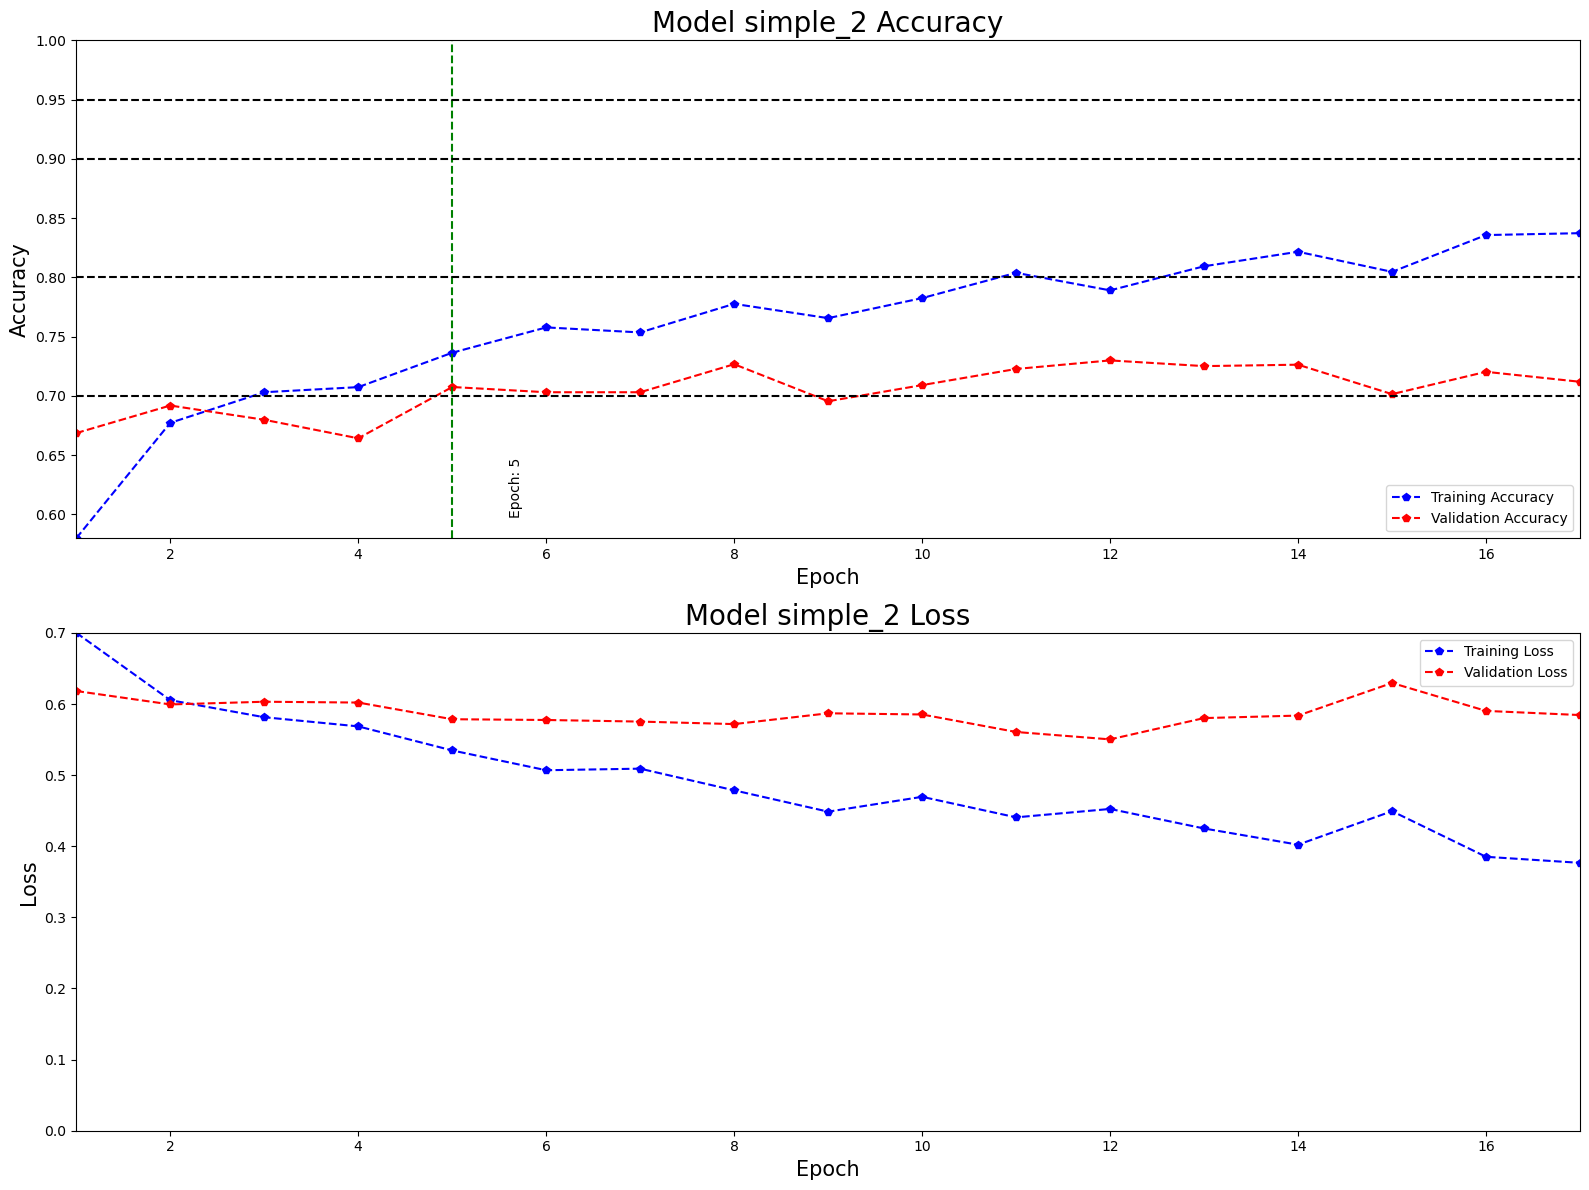

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Wczytaj historię modelu
df = pd.read_csv('history/history_simple_2.csv', index_col=0)
df.index += 1  # Indeks zaczyna się od 1, co odpowiada epokom

# Określ zakresy
max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

# Generowanie wykresów dla jednego modelu
fig = plt.figure(figsize=(16, 12))

# Wykres dokładności
ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model simple_2 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])

# Linie pomocnicze dla progów dokładności
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')

# Wykres funkcji straty
ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model simple_2 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')

# Zapis wykresu
plt.tight_layout()
plt.savefig(f'charts/train_history_simple_2.png', transparent=True, dpi=600)
plt.show()

In [41]:
model_1 = Sequential()

# Block 1
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_1.summary()
models.append("model_1")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history_model_1 = model_1.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es]
)

history_model_1_df = pd.DataFrame(history_model_1.history)
history_model_1_csv_file = 'history/history_model_1.csv'

with open(history_model_1_csv_file, mode='w') as f:
    history_model_1_df.to_csv(f)

Epoch 1/1000
 50/136 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.5125 - loss: 0.6931

C:\Users\matyj\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.5201 - loss: 0.6924 - val_accuracy: 0.5573 - val_loss: 0.6826
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5811 - loss: 0.6764 - val_accuracy: 0.6202 - val_loss: 0.6452
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 2:46 1s/step - accuracy: 0.6602 - loss: 0.6249

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.6486 - loss: 0.6292 - val_accuracy: 0.5509 - val_loss: 0.7031
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6032 - loss: 0.6595 - val_accuracy: 0.6510 - val_loss: 0.6265
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6320 - loss: 0.6369 - val_accuracy: 0.6687 - val_loss: 0.6034
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.6872 - loss: 0.5635 - val_accuracy: 0.6498 - val_loss: 0.6272
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.6694 - loss: 0.6040 - val_accuracy: 0.6787 - val_loss: 0.5927
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6950 - loss: 0.5701 - val_accuracy: 0.7332 - val_loss: 0.5321
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.7347 - loss: 0.5461 - val_accuracy: 0.7055 - val_loss: 0.5632
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7174 - loss: 0.5492 

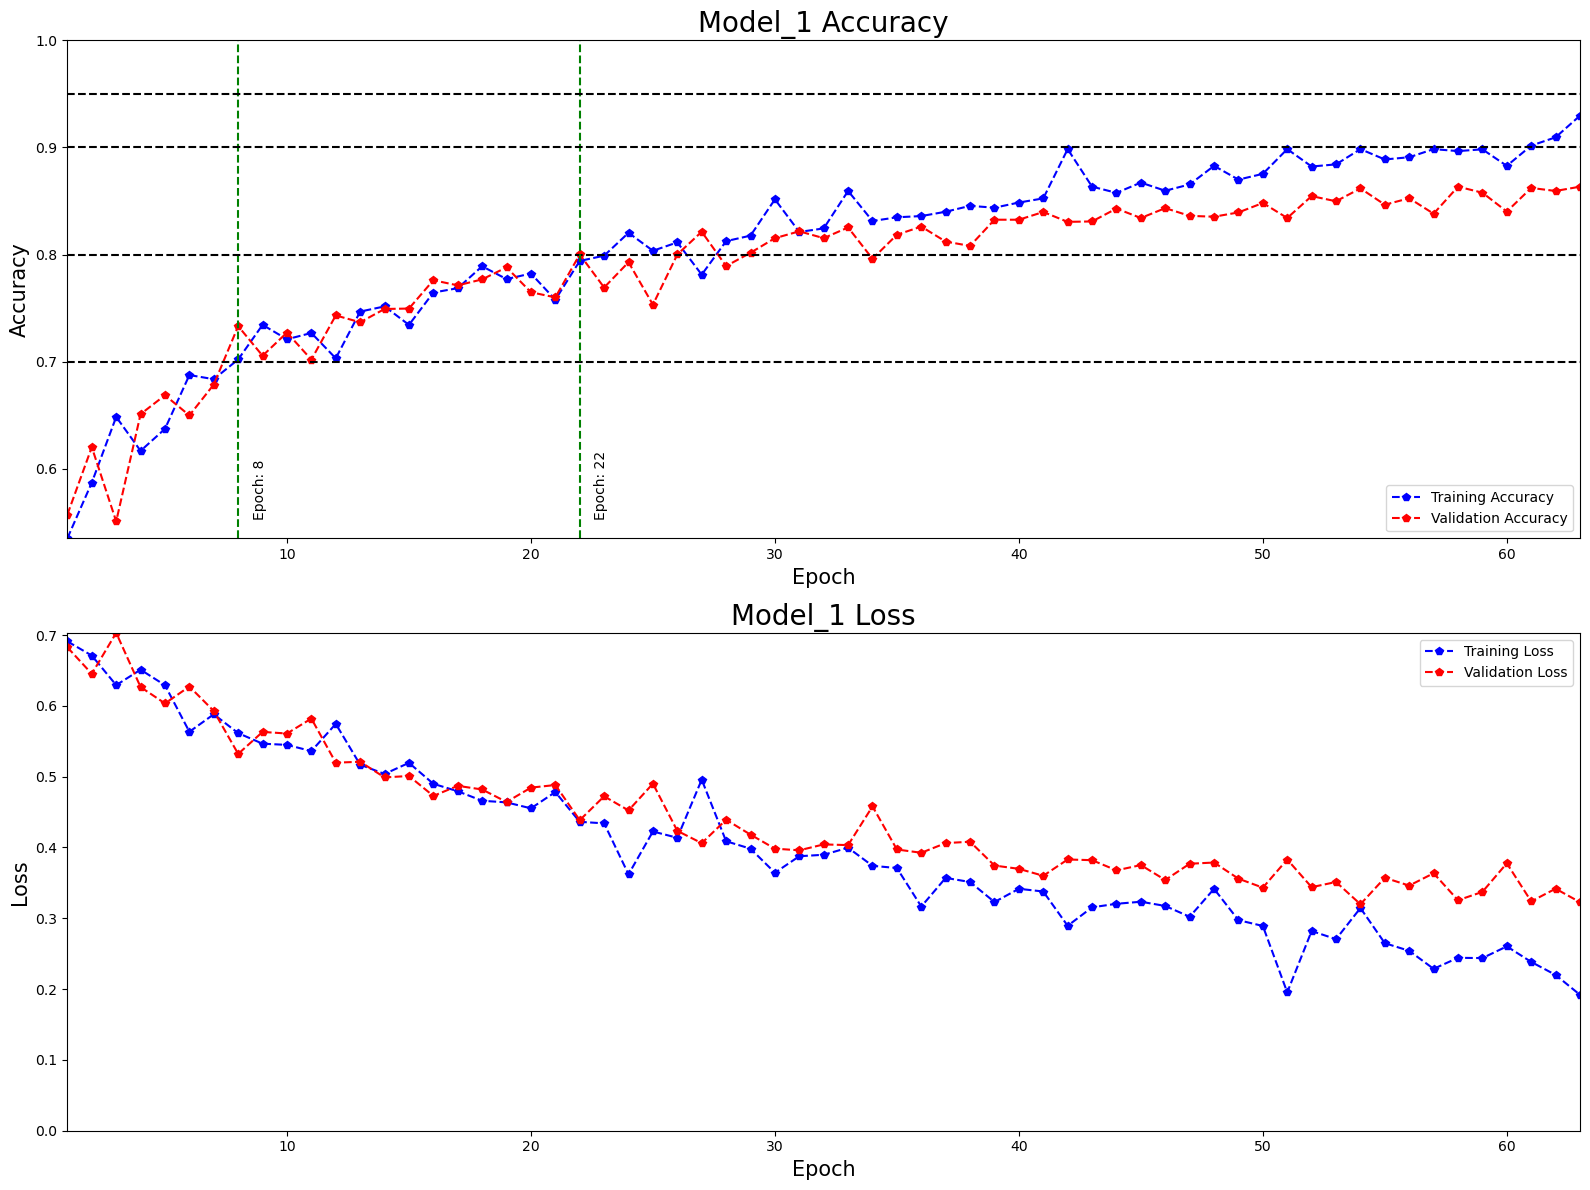

In [44]:
df = pd.read_csv('history/history_model_1.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_1 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_1 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_1.png', transparent=True, dpi=600)
plt.show()

In [45]:
model_2 = Sequential()

# Block 1
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_2.summary()
models.append("model_2")

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history_model_2 = model_2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es]
)

history_model_2_df = pd.DataFrame(history_model_2.history)
history_model_2_csv_file = 'history/history_model_2.csv'

with open(history_model_2_csv_file, mode='w') as f:
    history_model_2_df.to_csv(f)

Epoch 1/1000
 64/136 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.5005 - loss: 0.6932

C:\Users\matyj\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5026 - loss: 0.6927 - val_accuracy: 0.4968 - val_loss: 0.6910
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5484 - loss: 0.6824 - val_accuracy: 0.6006 - val_loss: 0.6594
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 2:18 1s/step - accuracy: 0.6484 - loss: 0.6403

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.6561 - loss: 0.6313 - val_accuracy: 0.5385 - val_loss: 0.6897
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.6027 - loss: 0.6547 - val_accuracy: 0.5978 - val_loss: 0.6514
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6011 - loss: 0.6514 - val_accuracy: 0.6174 - val_loss: 0.6435
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.5781 - loss: 0.6775 - val_accuracy: 0.6146 - val_loss: 0.6471
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6176 - loss: 0.6409 - val_accuracy: 0.6322 - val_loss: 0.6217
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6376 - loss: 0.6208 - val_accuracy: 0.6518 - val_loss: 0.6113
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.6797 - loss: 0.5459 - val_accuracy: 0.6967 - val_loss: 0.5776
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.6765 - loss: 0.5924 

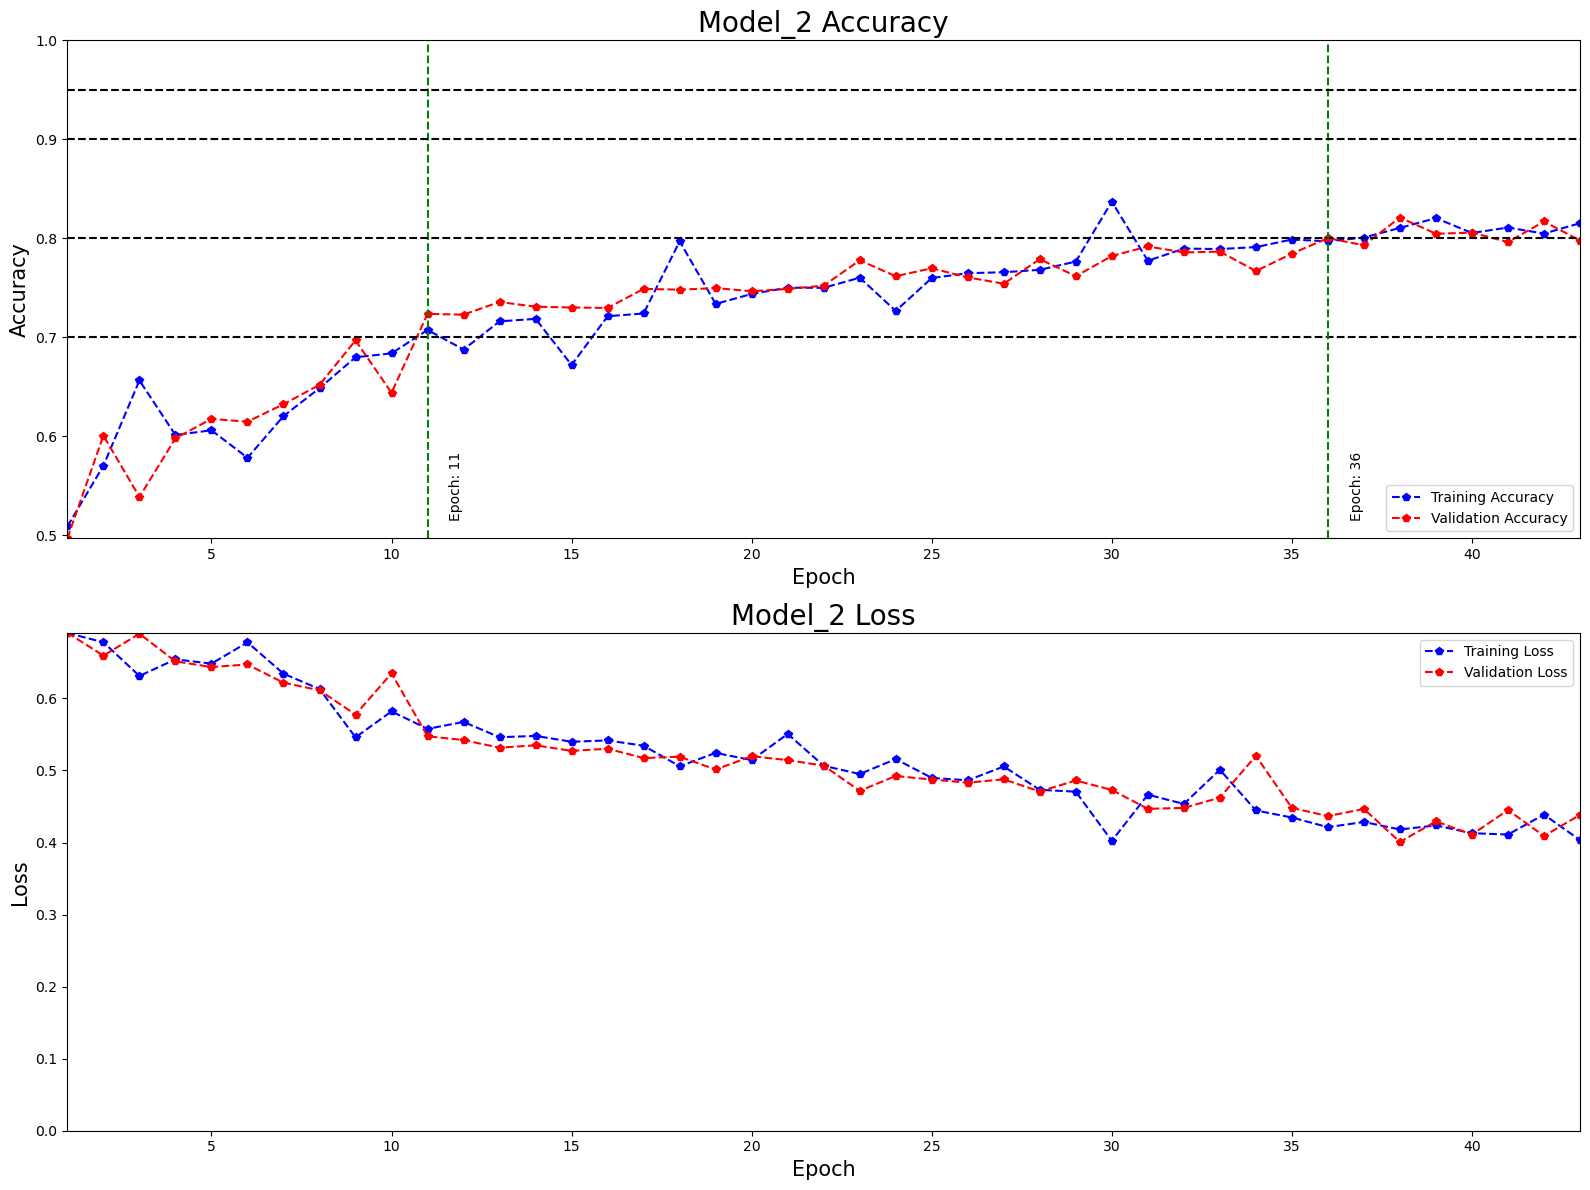

In [47]:
df = pd.read_csv('history/history_model_2.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_2 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_2 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_2.png', transparent=True, dpi=600)
plt.show()

In [49]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_3.summary()
models.append("model_3")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history_model_3 = model_3.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_3_df = pd.DataFrame(history_model_3.history)
history_model_3_csv_file = 'history/history_model_3.csv'
with open(history_model_3_csv_file, mode='w') as f:
    history_model_3_df.to_csv(f)

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
 87/136 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.4991 - loss: 0.6930

C:\Users\matyj\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.5004 - loss: 0.6929 - val_accuracy: 0.5136 - val_loss: 0.6884
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.5499 - loss: 0.6848 - val_accuracy: 0.5481 - val_loss: 0.6942
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 2:51 1s/step - accuracy: 0.4883 - loss: 0.6915

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.5075 - loss: 0.6891 - val_accuracy: 0.6174 - val_loss: 0.6435
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.6068 - loss: 0.6546 - val_accuracy: 0.6226 - val_loss: 0.6348
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.6170 - loss: 0.6380 - val_accuracy: 0.6214 - val_loss: 0.6565
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.6197 - loss: 0.6172 - val_accuracy: 0.6130 - val_loss: 0.6608
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.6548 - loss: 0.6151 - val_accuracy: 0.6903 - val_loss: 0.5823
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.6860 - loss: 0.5883 - val_accuracy: 0.7087 - val_loss: 0.5648
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.7265 - loss: 0.5533 - val_accuracy: 0.7135 - val_loss: 0.5698
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.6832 - loss: 0.5790 

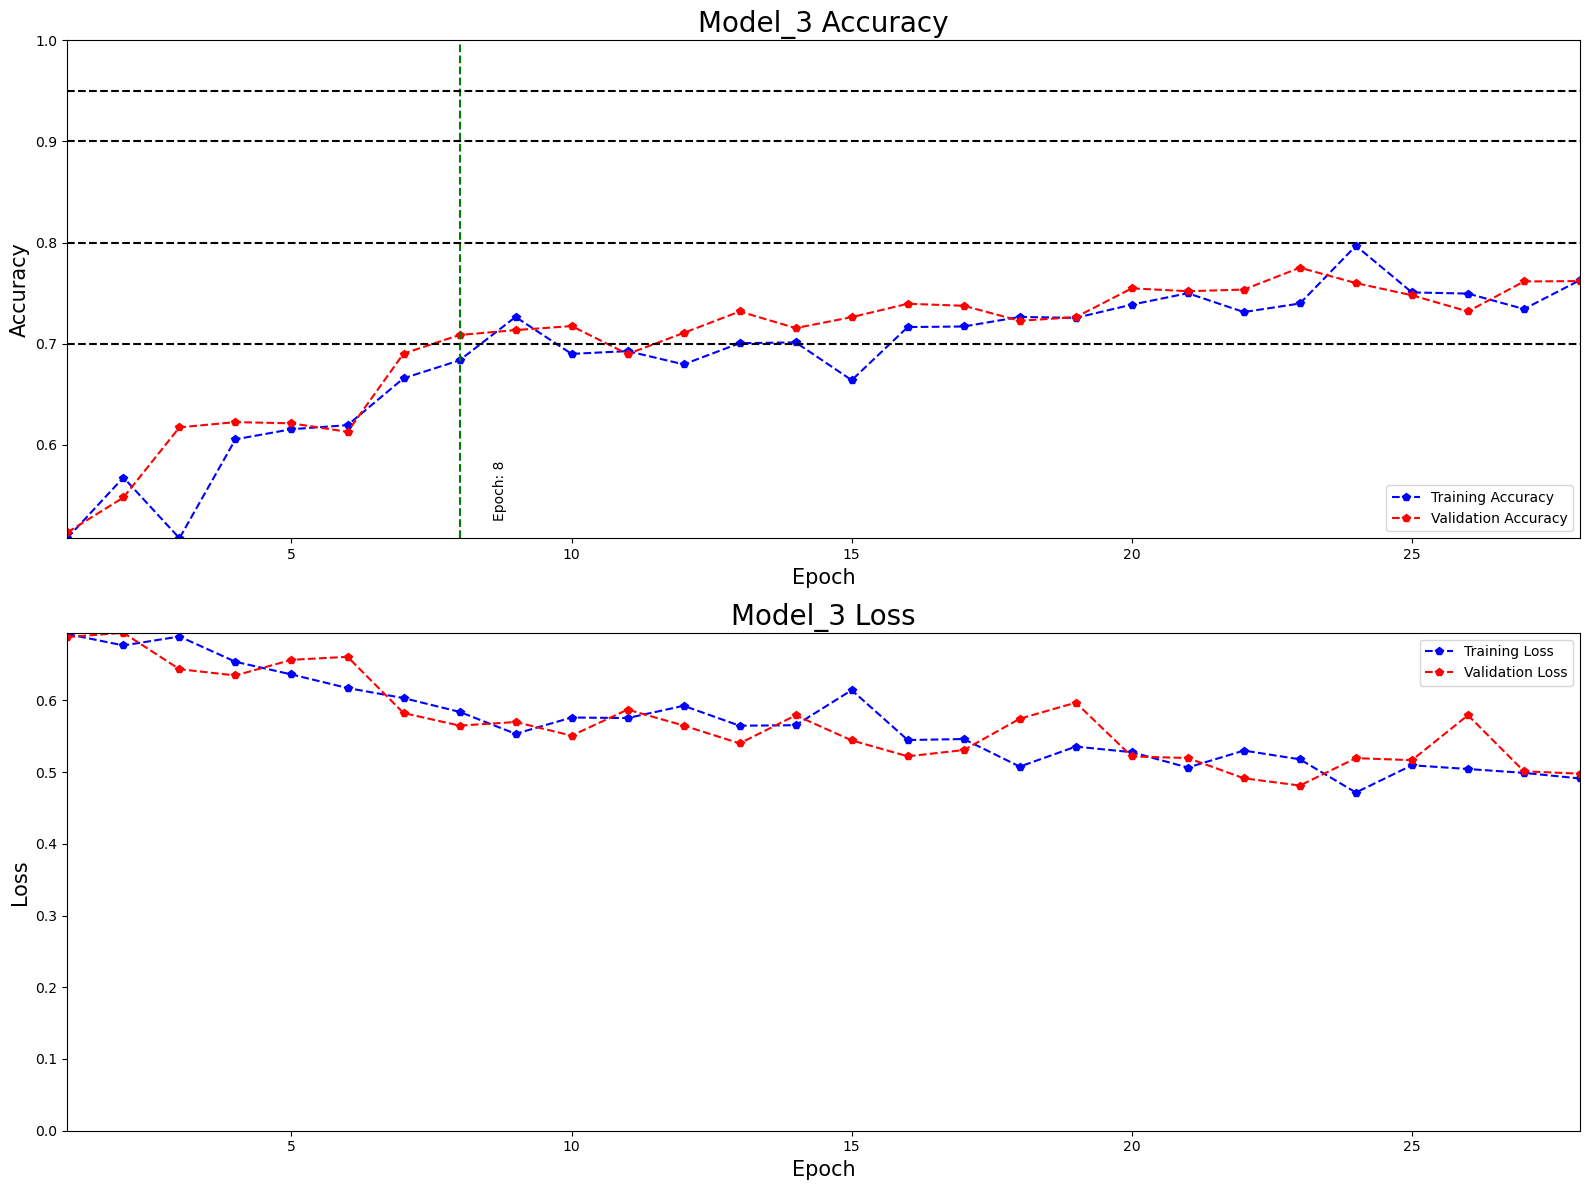

In [51]:
df = pd.read_csv('history/history_model_3.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_3 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_3 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_3.png', transparent=True, dpi=600)
plt.show()

In [53]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_4.summary()
models.append("model_4")

layer_name: input_layer_10 trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 9,209,857 (35.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [54]:
history_model_4 = model_4.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_4_df = pd.DataFrame(history_model_4.history)
history_model_4_csv_file = 'history/history_model_4.csv'
with open(history_model_4_csv_file, mode='w') as f:
    history_model_4_df.to_csv(f)

Epoch 1/1000
 19/136 ━━━━━━━━━━━━━━━━━━━━ 16:49 9s/step - accuracy: 0.5611 - loss: 0.7428

C:\Users\matyj\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 1623s 12s/step - accuracy: 0.7199 - loss: 0.5361 - val_accuracy: 0.8281 - val_loss: 0.3724
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1823s 13s/step - accuracy: 0.8813 - loss: 0.2867 - val_accuracy: 0.9299 - val_loss: 0.1768
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 20:12 9s/step - accuracy: 0.8750 - loss: 0.2971 

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9058 - loss: 0.2522 - val_accuracy: 0.9339 - val_loss: 0.1750
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1662s 12s/step - accuracy: 0.9018 - loss: 0.2277 - val_accuracy: 0.9439 - val_loss: 0.1269
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1720s 13s/step - accuracy: 0.9230 - loss: 0.1991 - val_accuracy: 0.9515 - val_loss: 0.1322
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.9143 - loss: 0.1797 - val_accuracy: 0.9523 - val_loss: 0.1333
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1474s 11s/step - accuracy: 0.9240 - loss: 0.1781 - val_accuracy: 0.9551 - val_loss: 0.1228
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1463s 11s/step - accuracy: 0.9358 - loss: 0.1587 - val_accuracy: 0.9567 - val_loss: 0.1342
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.9609 - loss: 0.1037 - val_accuracy: 0.9479 - val_loss: 0.1557
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2110s 15s/step - accuracy: 0.9369 - loss: 0.1

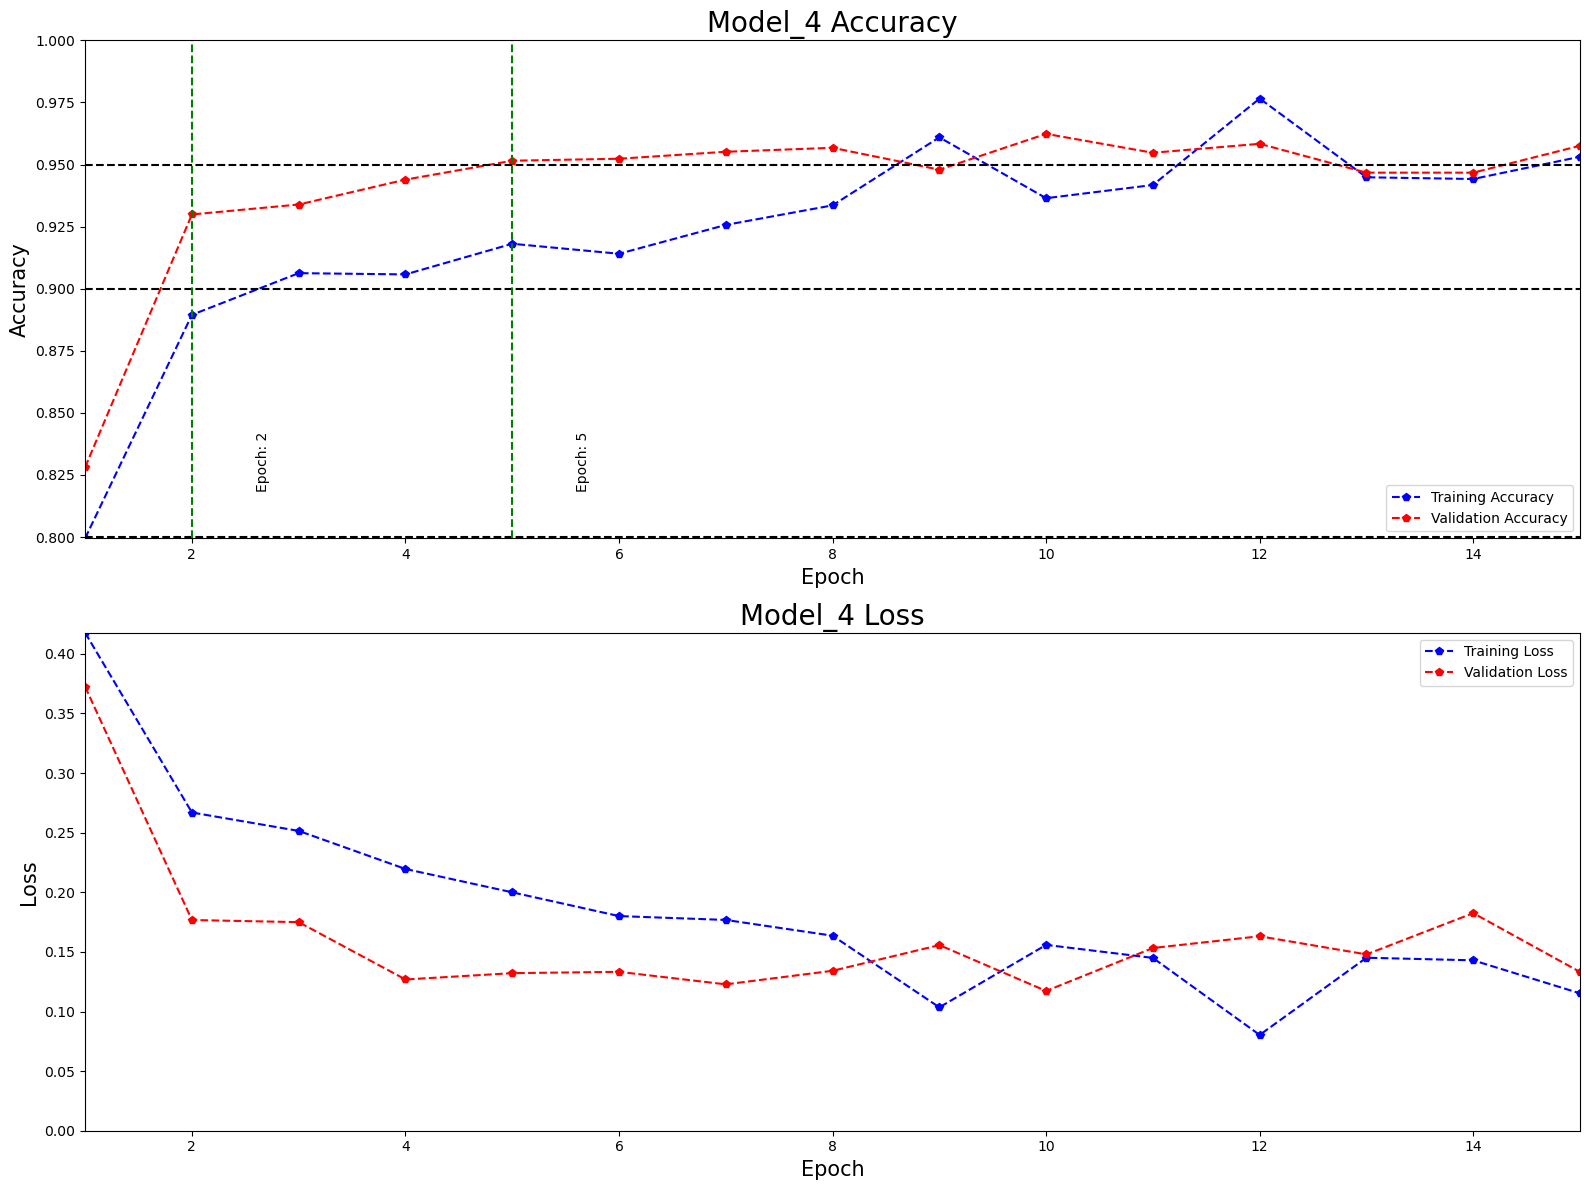

In [55]:
df = pd.read_csv('history/history_model_4.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_4 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_4 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_4.png', transparent=True, dpi=600)
plt.show()

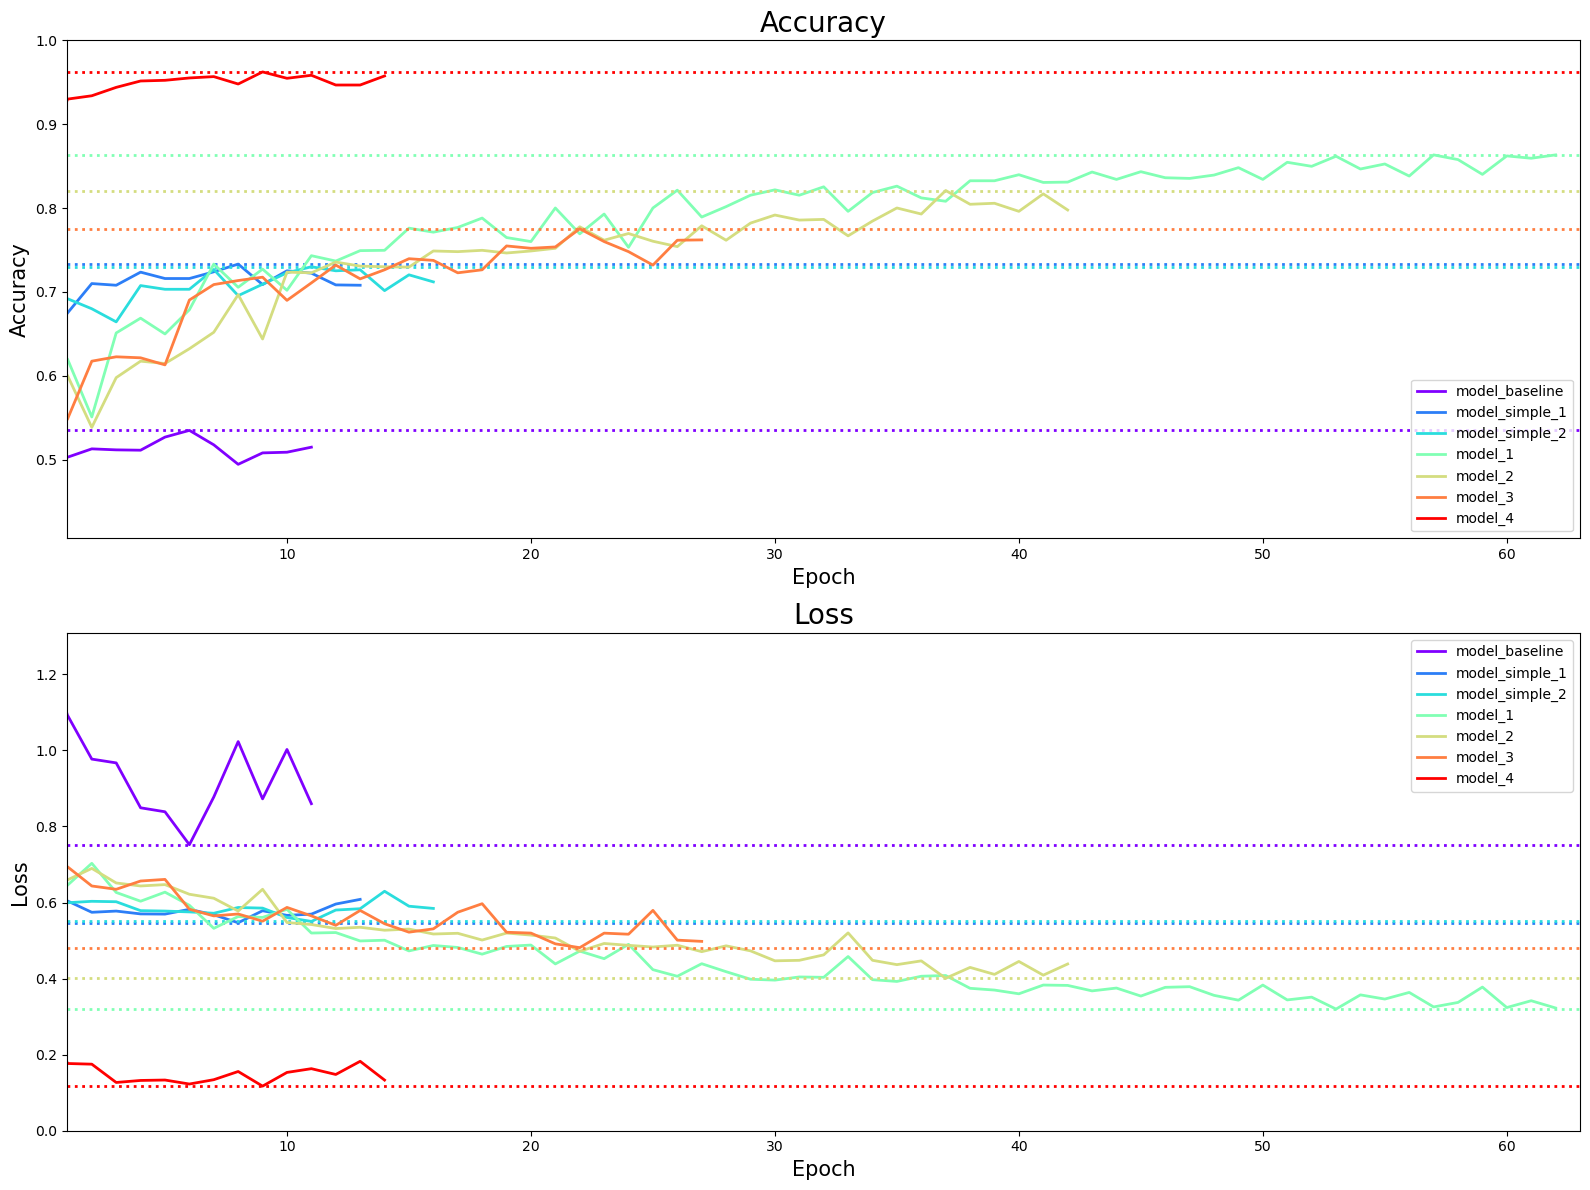

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

models = ["model_baseline", "model_simple_1", "model_simple_2", "model_1", "model_2", "model_3", "model_4"]
file_mapping = {
    "model_baseline": "history_baseline.csv",
    "model_simple_1": "history_simple_1.csv",
    "model_simple_2": "history_simple_2.csv",
    "model_1": "history_model_1.csv",
    "model_2": "history_model_2.csv",
    "model_3": "history_model_3.csv",
    "model_4": "history_model_4.csv",
}


colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))


max_epoch = 0
min_acc = 1
max_loss = 0


for model in models:
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    max_epoch = max(max_epoch, len(df))
    min_acc = min(min_acc, df[['accuracy', 'val_accuracy']].min().min())
    max_loss = max(max_loss, df[['loss', 'val_loss']].max().max())


fig, axes = plt.subplots(2, 1, figsize=(16, 12))


for model, color in zip(models, colors):
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    axes[0].plot(df['val_accuracy'], label=f'{model}', color=color, linewidth=2)
    axes[0].axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=2)

axes[0].set_title('Accuracy', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=15)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_xlim([1, max_epoch])
axes[0].set_ylim([min_acc, 1])
axes[0].legend(loc='lower right')


for model, color in zip(models, colors):
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    axes[1].plot(df['val_loss'], label=f'{model}', color=color, linewidth=2)
    axes[1].axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=2)

axes[1].set_title('Loss', fontsize=20)
axes[1].set_ylabel('Loss', fontsize=15)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_xlim([1, max_epoch])
axes[1].set_ylim([0, max_loss])
axes[1].legend(loc='upper right')


plt.tight_layout()
plt.savefig('charts/comparison_accuracy_loss.png', dpi=600)
plt.show()


In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = "dataset/test"  # Zmień na ścieżkę do Twoich danych testowych


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  
    batch_size=32,
    class_mode='binary',  
    shuffle=False  
)


Found 2500 images belonging to 2 classes.


In [67]:
from sklearn.metrics import classification_report

model_objects = {
    "model_baseline": model_baseline,
    "model_simple_1": model_simple_1,
    "model_simple_2": model_simple_2,
    "model_1": model_1,
    "model_2": model_2,
    "model_3": model_3,
    "model_4": model_4,
}

for model_name, model in model_objects.items():

    predictions = (model.predict(test_generator) > 0.5).astype("int32")
    true_labels = test_generator.classes

    report = classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys())
    print(f"Classification Report for {model_name}:\n")
    print(report)


C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 422ms/step
Classification Report for model_baseline:

              precision    recall  f1-score   support

         Cat       0.74      0.16      0.27      1250
         Dog       0.53      0.94      0.68      1250

    accuracy                           0.55      2500
   macro avg       0.63      0.55      0.47      2500
weighted avg       0.63      0.55      0.47      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step
Classification Report for model_simple_1:

              precision    recall  f1-score   support

         Cat       0.75      0.68      0.72      1250
         Dog       0.71      0.78      0.74      1250

    accuracy                           0.73      2500
   macro avg       0.73      0.73      0.73      2500
weighted avg       0.73      0.73      0.73      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step
Classification Report for model_simple_2:

              precision    recall  f1-score   support

         Cat       0.74      0.76   

In [68]:
model_5 = Sequential()

# Block 1
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Flatten())
model_5.add(Dropout(0.5))
model_5.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_5.add(Dense(units=1, activation='sigmoid'))


model_5.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
model_5.summary()


C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,177,089 (12.12 MB)

 Trainable params: 3,177,089 (12.12 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history_model_5 = model_5.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_5_df = pd.DataFrame(history_model_5.history)
history_model_5_csv_file = 'history/history_model_5.csv'
with open(history_model_5_csv_file, mode='w') as f:
    history_model_5_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 533s 4s/step - accuracy: 0.4949 - loss: 1.6635 - val_accuracy: 0.4956 - val_loss: 1.5494
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 583s 4s/step - accuracy: 0.5128 - loss: 1.5152 - val_accuracy: 0.5897 - val_loss: 1.4181
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 6:47 3s/step - accuracy: 0.4922 - loss: 1.4183

C:\Users\matyj\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 49s 339ms/step - accuracy: 0.4999 - loss: 1.4180 - val_accuracy: 0.5032 - val_loss: 1.4165
Epoch 4/1000
120/136 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - accuracy: 0.5210 - loss: 1.3912

C:\Users\matyj\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 559s 4s/step - accuracy: 0.5214 - loss: 1.3877 - val_accuracy: 0.5725 - val_loss: 1.3049
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.5415 - loss: 1.2799 - val_accuracy: 0.5140 - val_loss: 1.2183
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - accuracy: 0.6187 - loss: 1.1934 - val_accuracy: 0.6074 - val_loss: 1.1829
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.5775 - loss: 1.1777 - val_accuracy: 0.5873 - val_loss: 1.1104
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 637s 5s/step - accuracy: 0.5965 - loss: 1.0969 - val_accuracy: 0.6110 - val_loss: 1.0390
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.6247 - loss: 1.0238 - val_accuracy: 0.6454 - val_loss: 1.0153
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.6022 - loss: 1.0312 - val_accuracy: 0.6410 - val_loss: 0.9586
Epoch 11/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.6033 - loss: 0.9727 -

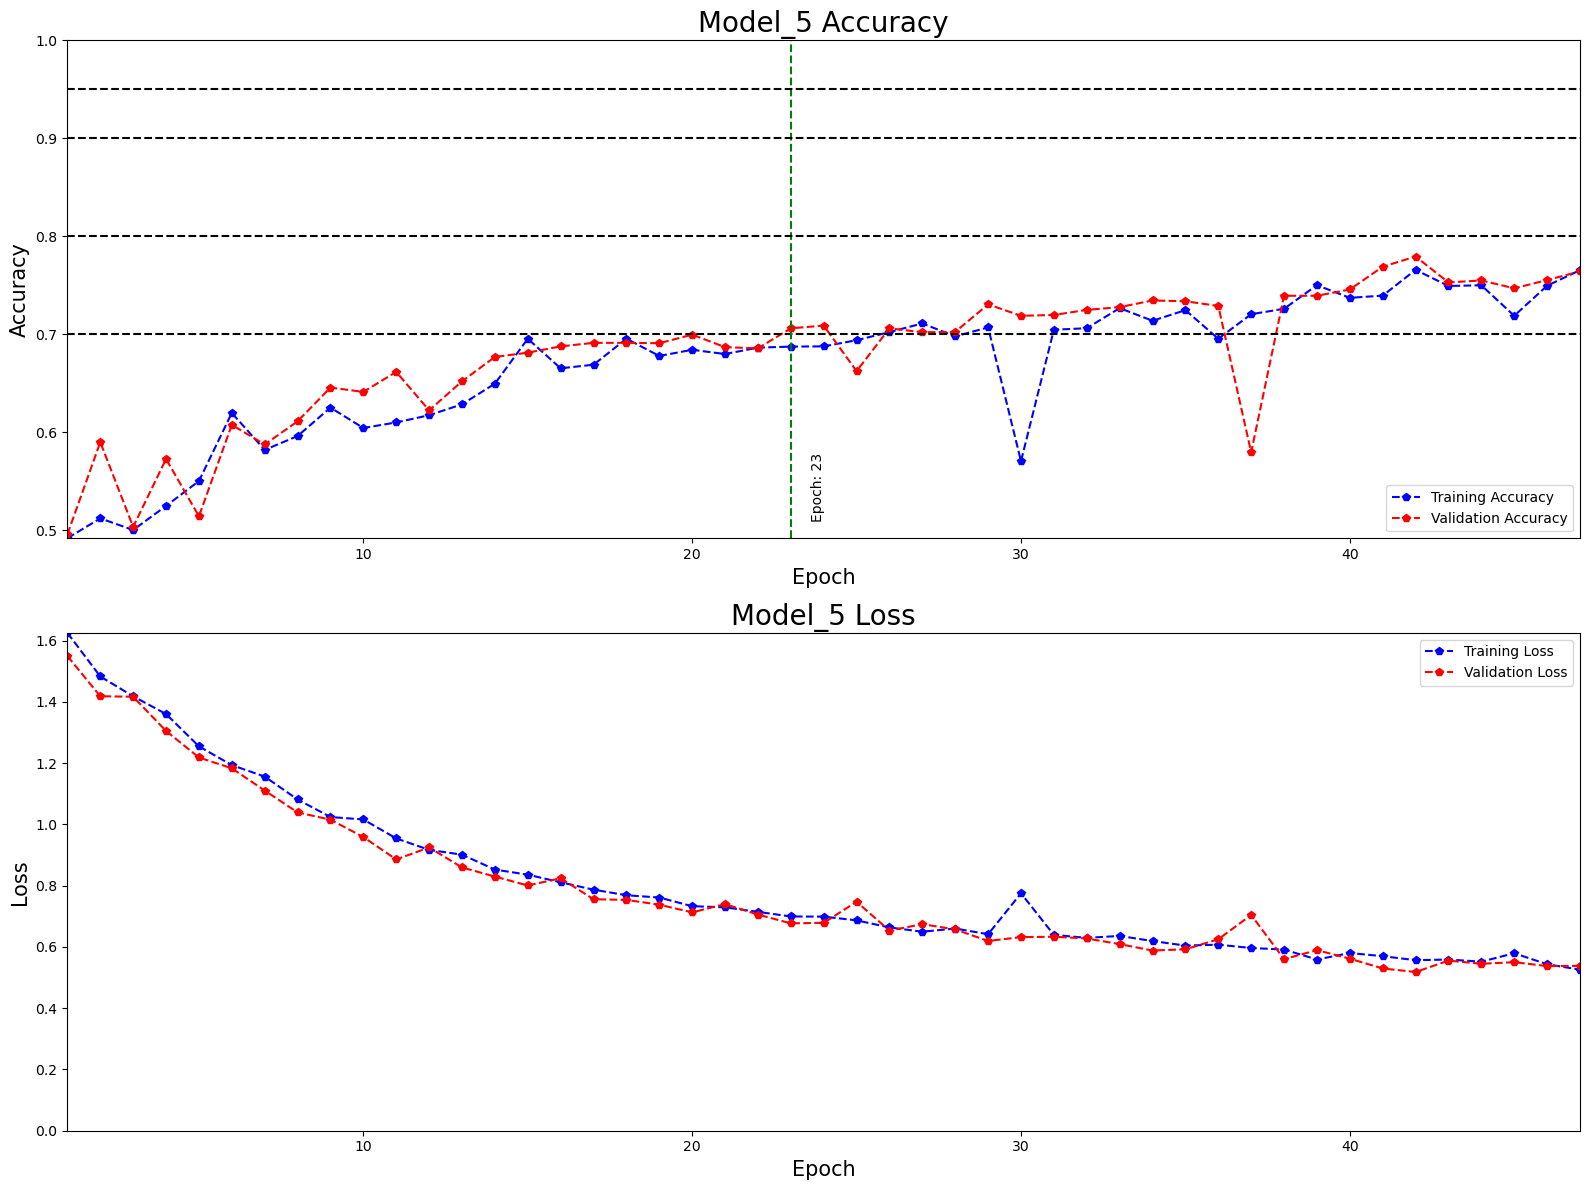

In [70]:
df = pd.read_csv('history/history_model_5.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_5 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_5 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_5.png', transparent=True, dpi=600)
plt.show()

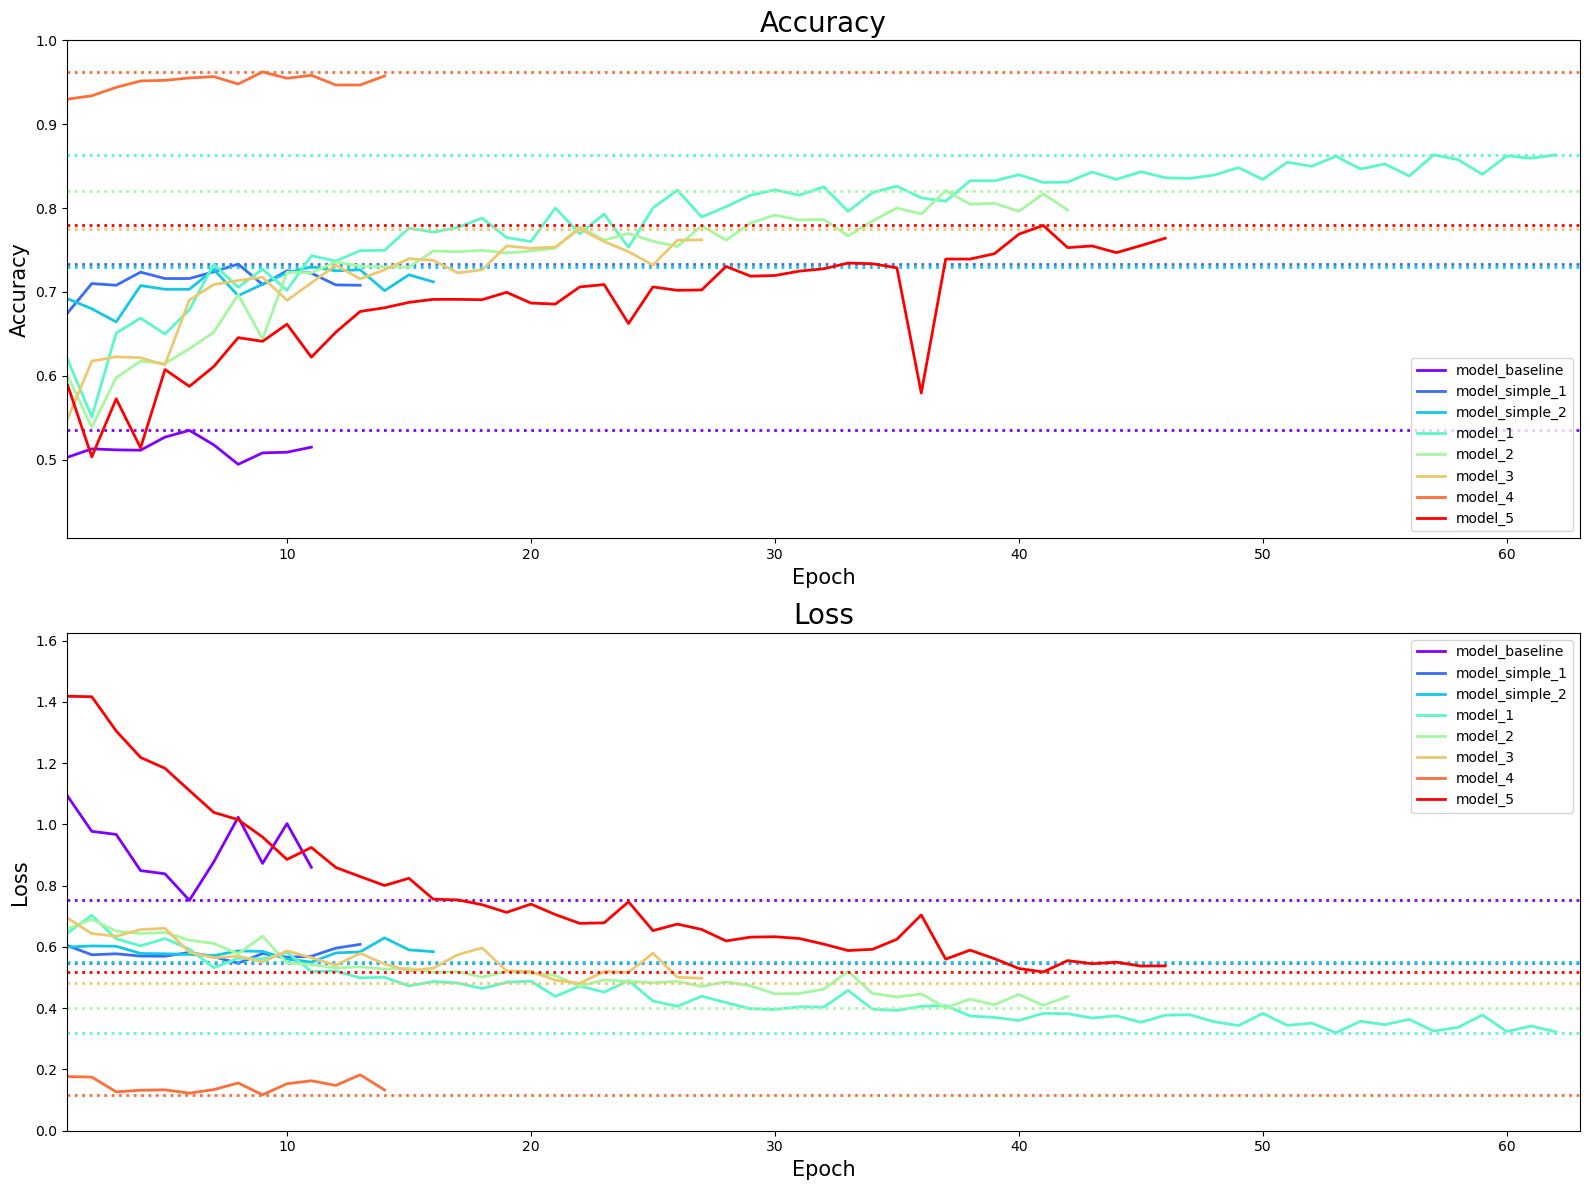

In [72]:
models = ["model_baseline", "model_simple_1", "model_simple_2", "model_1", "model_2", "model_3", "model_4", "model_5"]
file_mapping = {
    "model_baseline": "history_baseline.csv",
    "model_simple_1": "history_simple_1.csv",
    "model_simple_2": "history_simple_2.csv",
    "model_1": "history_model_1.csv",
    "model_2": "history_model_2.csv",
    "model_3": "history_model_3.csv",
    "model_4": "history_model_4.csv",
    "model_5": "history_model_5.csv",
}


colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))


max_epoch = 0
min_acc = 1
max_loss = 0


for model in models:
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    max_epoch = max(max_epoch, len(df))
    min_acc = min(min_acc, df[['accuracy', 'val_accuracy']].min().min())
    max_loss = max(max_loss, df[['loss', 'val_loss']].max().max())


fig, axes = plt.subplots(2, 1, figsize=(16, 12))


for model, color in zip(models, colors):
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    axes[0].plot(df['val_accuracy'], label=f'{model}', color=color, linewidth=2)
    axes[0].axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=2)

axes[0].set_title('Accuracy', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=15)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_xlim([1, max_epoch])
axes[0].set_ylim([min_acc, 1])
axes[0].legend(loc='lower right')


for model, color in zip(models, colors):
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    axes[1].plot(df['val_loss'], label=f'{model}', color=color, linewidth=2)
    axes[1].axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=2)

axes[1].set_title('Loss', fontsize=20)
axes[1].set_ylabel('Loss', fontsize=15)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_xlim([1, max_epoch])
axes[1].set_ylim([0, max_loss])
axes[1].legend(loc='upper right')


plt.tight_layout()
plt.savefig('charts/comparison_accuracy_loss.png', dpi=600)
plt.show()


In [73]:
model_objects = {
    "model_baseline": model_baseline,
    "model_simple_1": model_simple_1,
    "model_simple_2": model_simple_2,
    "model_1": model_1,
    "model_2": model_2,
    "model_3": model_3,
    "model_4": model_4,
    "model_5": model_5,
}

for model_name, model in model_objects.items():

    predictions = (model.predict(test_generator) > 0.5).astype("int32")
    true_labels = test_generator.classes

    report = classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys())
    print(f"Classification Report for {model_name}:\n")
    print(report)


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step
Classification Report for model_baseline:

              precision    recall  f1-score   support

         Cat       0.74      0.16      0.27      1250
         Dog       0.53      0.94      0.68      1250

    accuracy                           0.55      2500
   macro avg       0.63      0.55      0.47      2500
weighted avg       0.63      0.55      0.47      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step
Classification Report for model_simple_1:

              precision    recall  f1-score   support

         Cat       0.75      0.68      0.72      1250
         Dog       0.71      0.78      0.74      1250

    accuracy                           0.73      2500
   macro avg       0.73      0.73      0.73      2500
weighted avg       0.73      0.73      0.73      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step
Classification Report for model_simple_2:

              precision    recall  f1-score   support

         Cat       0.74      0.76   